# **Model 5**

제작 : 박진재<br>
사용 기법 : DenseNet121 TL<br>
<img src="https://miro.medium.com/v2/resize:fit:678/1*u4hyohOF9SIRRLBAzqYXfQ.jpeg" width="400px"></img>

> **모델 간략한 소개**

<big>Dense connection은 기능 재사용을 촉진하여 네트워크가 보다 간결한 표현을 학습하고 계층적 기능을 더 잘 추출</big>

1. DenseNet121<br>
2. 기존모델 끝 3레이어 동결해제<br>
3. EarlyStopping<br>

> **모델 성능**

ACC : **84.27672982215881%** <br>
LOSS : **0.36929842829704285** <br>
F1 SCORE : **0.5026528349699082** <br>

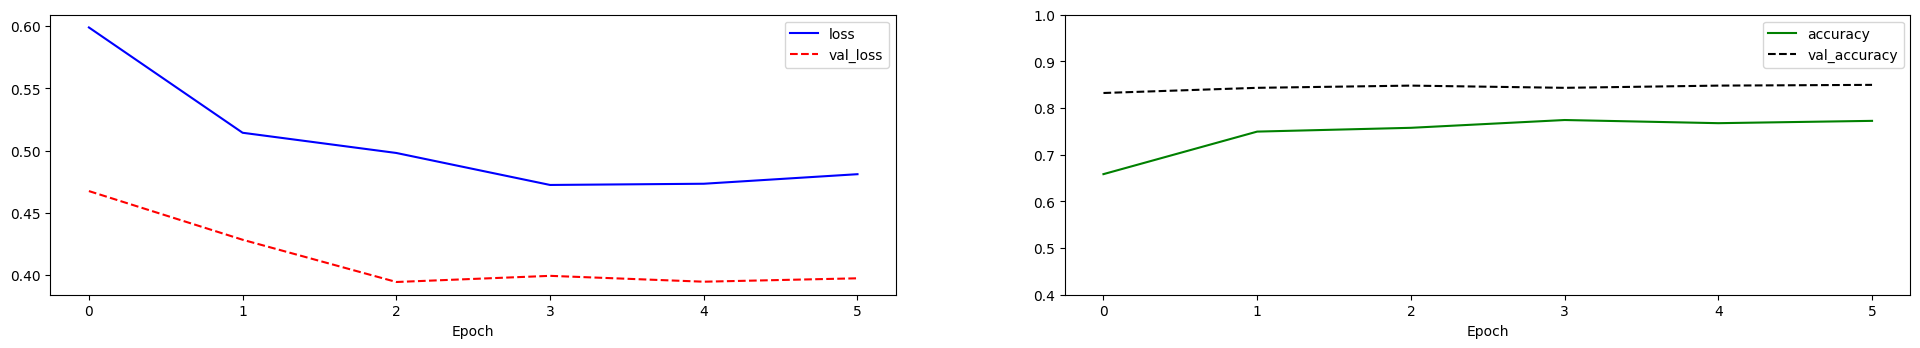

### **GPU 설정**

In [1]:
import tensorflow as tf

# GPU 디바이스 확인
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# TensorFlow가 GPU를 사용할 수 있도록 설정합니다.
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU is enabled')
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Num GPUs Available:  1
GPU is enabled


### **모듈 import**

In [2]:
import os
import tensorflow as tf

### **프로젝트 공통 설정**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
test_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/test'
val_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/val'
train_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/train'

In [5]:
def count_data_number(path, name):
    pneumonia = 0
    normal = 0

    # pneumonia 폴더 내의 파일 개수 계산
    pneumonia_path = os.path.join(path, 'pneumonia')
    if os.path.exists(pneumonia_path):
        pneumonia = len(os.listdir(pneumonia_path))

    # normal 폴더 내의 파일 개수 계산
    normal_path = os.path.join(path, 'normal')
    if os.path.exists(normal_path):
        normal = len(os.listdir(normal_path))

    print(name, "pneumonia data : ", pneumonia)
    print(name, "normal data : ", normal)
    print()

    return pneumonia, normal

In [6]:
count_data_number(train_data_path, "train")
count_data_number(val_data_path, "val")
count_data_number(test_data_path, "test")

train pneumonia data :  0
train normal data :  0

val pneumonia data :  0
val normal data :  0

test pneumonia data :  0
test normal data :  0



(0, 0)

## **모델 개발**

In [7]:
input_shape = (200, 200, 3)
num_classes = 2
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 2216 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 318 images belonging to 2 classes.


In [8]:
model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
x = tf.keras.layers.Conv2D(
    128,
    (1, 1),
    padding = 'same',
    activation = 'relu'
)(model.output)
x = tf.keras.layers.Conv2D(
    kernel_size=(3,3),
    filters=64,
    padding='same',
    activation='relu'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=model.input, outputs=predictions)

for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-3:]:
    layer.trainable = True

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [9]:
epochs = 20

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    batch_size=10,
    callbacks=[early_stop]
)

Epoch 1/20
70/70 [==============================] - 1541s 22s/step - loss: 0.6559 - accuracy: 0.6209 - val_loss: 0.5285 - val_accuracy: 0.7690
Epoch 2/20
70/70 [==============================] - 46s 661ms/step - loss: 0.5789 - accuracy: 0.6850 - val_loss: 0.4667 - val_accuracy: 0.8497
Epoch 3/20
70/70 [==============================] - 46s 662ms/step - loss: 0.5589 - accuracy: 0.7184 - val_loss: 0.4549 - val_accuracy: 0.8386
Epoch 4/20
70/70 [==============================] - 48s 684ms/step - loss: 0.5509 - accuracy: 0.7202 - val_loss: 0.4376 - val_accuracy: 0.8560
Epoch 5/20
70/70 [==============================] - 48s 682ms/step - loss: 0.5335 - accuracy: 0.7437 - val_loss: 0.4282 - val_accuracy: 0.8592
Epoch 6/20
70/70 [==============================] - 47s 676ms/step - loss: 0.5156 - accuracy: 0.7428 - val_loss: 0.4099 - val_accuracy: 0.8418
Epoch 7/20
70/70 [==============================] - 48s 682ms/step - loss: 0.5098 - accuracy: 0.7532 - val_loss: 0.4119 - val_accuracy: 0.8402

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

10/10 [==============================] - 245s 27s/step - loss: 0.4086 - accuracy: 0.8648
Test Loss: 0.4086211919784546
Test Accuracy: 0.8647798895835876


In [13]:
model.save('/content/drive/MyDrive/PneumoniaClassifier/model/model5.h5')

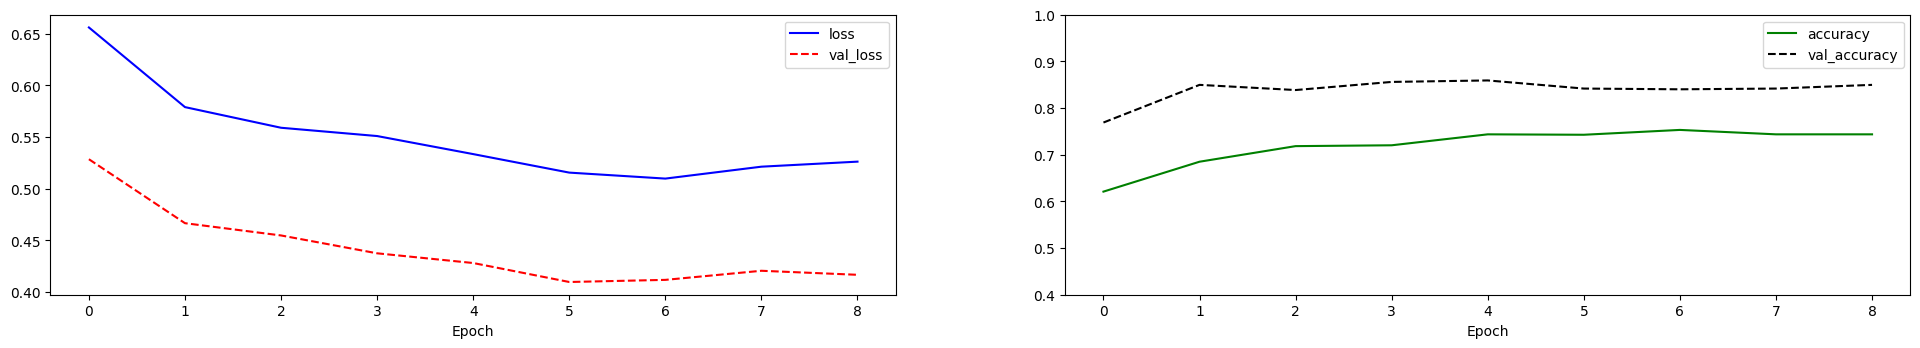

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r--',label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],'g-',label='accuracy')
plt.plot(history.history['val_accuracy'],'k--',label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.4,1.0)
plt.legend()

## **모델 평가**

In [12]:
from sklearn.metrics import f1_score
import numpy as np
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = test_generator.classes

f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('F1 Score:', f1)

10/10 [==============================] - 8s 480ms/step
F1 Score: 0.5121878804073513
